In [ ]:
!pip install optuna
!pip install catboost
!pip install lightgbm
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.5 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import os

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [ ]:
SEED = 27
N_FOLDS = 5
TARGET = 'Target'

# **Loading and processing DataSets**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
print(train.shape, test.shape)

(76518, 37) (51012, 36)


In [ ]:
# Feature Distribution Using Variable Tables
cat_features = [
    'Marital status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]


for col in cat_features:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [ ]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['category', 'object']).columns
cat_features = [X.columns.get_loc(col) for col in categorical_cols]

# Apply one-hot encoding to categorical columns for XGBoost
X_encoded = pd.get_dummies(X, columns=categorical_cols)
test_encoded = pd.get_dummies(test, columns=categorical_cols)

# Align the train and test dataframes by columns
X_encoded, test_encoded = X_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

# Defining Training and Cross Validation Functions

In [ ]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        oof_preds = np.zeros(X.shape[0])
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)

            y_pred_probs = self.model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)

            oof_pred_probs[val_idx] = y_pred_probs
            oof_preds[val_idx] = y_pred

            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)

            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')

        print(f'\n------ Accuracy: {np.mean(accs):.6f} ± {np.std(accs):.6f}')
        print(f'------ AUC:      {np.mean(aucs):.6f} ± {np.std(aucs):.6f}\n\n')

        return self.model, oof_pred_probs, oof_preds, accs, aucs

In [ ]:
accuracies = {}
aucs = {}

test_pred_probs = {}
oof_pred_probs = {}
oof_preds = {}

In [ ]:
xgb_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'random_state': 42,
    'enable_categorical': True  # Enable categorical data handling
}
xgb_model = XGBClassifier(**xgb_params)
xgb_model, xgb_oof_pred_probs, xgb_oof_preds, xgb_accs, xgb_aucs = Trainer(xgb_model).fit(X, y)
oof_pred_probs['XGB'] = xgb_oof_pred_probs
oof_preds['XGB'] = xgb_oof_preds
test_pred_probs['XGB'] = xgb_model.predict_proba(test)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs

Training XGBClassifier
--- Fold 1 - Accuracy: 0.833769, AUC: 0.929240
--- Fold 2 - Accuracy: 0.833116, AUC: 0.930534
--- Fold 3 - Accuracy: 0.831286, AUC: 0.927797
--- Fold 4 - Accuracy: 0.830621, AUC: 0.928072
--- Fold 5 - Accuracy: 0.824871, AUC: 0.922627

------ Accuracy: 0.830733 ± 0.003149
------ AUC:      0.927654 ± 0.002694




In [ ]:
cb_params = {
    'iterations': 100,
    'depth': 5,
    'learning_rate': 0.1,
    'loss_function': 'MultiClass',
    'random_seed': SEED,
    'verbose': 0
}
cb_model = CatBoostClassifier(**cb_params, cat_features=cat_features)
cb_model, cb_oof_pred_probs, cb_oof_preds, cb_accs, cb_aucs = Trainer(cb_model).fit(X, y)
oof_pred_probs['CB'] = cb_oof_pred_probs
oof_preds['CB'] = cb_oof_preds
test_pred_probs['CB'] = cb_model.predict_proba(test)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs


Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.827953, AUC: 0.924070
--- Fold 2 - Accuracy: 0.828215, AUC: 0.925254
--- Fold 3 - Accuracy: 0.825340, AUC: 0.922293
--- Fold 4 - Accuracy: 0.824675, AUC: 0.922913
--- Fold 5 - Accuracy: 0.819513, AUC: 0.917792

------ Accuracy: 0.825139 ± 0.003140
------ AUC:      0.922465 ± 0.002546




In [ ]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model, lgbm_oof_pred_probs, lgbm_oof_preds, lgbm_accs, lgbm_aucs = Trainer(lgbm_model).fit(X, y)
oof_pred_probs['LGBM'] = lgbm_oof_pred_probs
oof_preds['LGBM'] = lgbm_oof_preds
test_pred_probs['LGBM'] = lgbm_model.predict_proba(test)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs

Training LGBMClassifier
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 36
[LightGBM] [Info] Start training from score -1.106863
[LightGBM] [Info] Start training from score -1.633477
[LightGBM] [Info] Start training from score -0.746218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [ ]:
hgb_params = {
    'max_iter': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'l2_regularization': 0.1,
    'early_stopping': True,
    'random_state': 42
}
hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_model, hgb_oof_pred_probs, hgb_oof_preds, hgb_accs, hgb_aucs = Trainer(hgb_model).fit(X, y)
oof_pred_probs['HGB'] = hgb_oof_pred_probs
oof_preds['HGB'] = hgb_oof_preds
test_pred_probs['HGB'] = hgb_model.predict_proba(test)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs

Training HistGradientBoostingClassifier
--- Fold 1 - Accuracy: 0.834030, AUC: 0.928613
--- Fold 2 - Accuracy: 0.832854, AUC: 0.929846
--- Fold 3 - Accuracy: 0.832985, AUC: 0.927479
--- Fold 4 - Accuracy: 0.831406, AUC: 0.927913
--- Fold 5 - Accuracy: 0.822911, AUC: 0.923572

------ Accuracy: 0.830837 ± 0.004050
------ AUC:      0.927485 ± 0.002114




In [ ]:
from sklearn.impute import SimpleImputer
gb_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'random_state': 42
}
gb_model = GradientBoostingClassifier(**gb_params)
gb_model, gb_oof_pred_probs, gb_oof_preds, gb_accs, gb_aucs = Trainer(gb_model).fit(X, y)
oof_pred_probs['GB'] = gb_oof_pred_probs
oof_preds['GB'] = gb_oof_preds
imputer = SimpleImputer(strategy='mean')
test_imputed = imputer.fit_transform(test)
test_pred_probs['GB'] = gb_model.predict_proba(test_imputed)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs

Training GradientBoostingClassifier
--- Fold 1 - Accuracy: 0.832135, AUC: 0.928168
--- Fold 2 - Accuracy: 0.833573, AUC: 0.930176
--- Fold 3 - Accuracy: 0.831809, AUC: 0.926939
--- Fold 4 - Accuracy: 0.830621, AUC: 0.928187
--- Fold 5 - Accuracy: 0.822584, AUC: 0.922631

------ Accuracy: 0.830144 ± 0.003896
------ AUC:      0.927220 ± 0.002518




In [ ]:
# Define rf_params
from sklearn.impute import SimpleImputer
rf_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'random_state': 42
}

rf_model = RandomForestClassifier(**rf_params)
rf_model, rf_oof_pred_probs, rf_oof_preds, rf_accs, rf_aucs = Trainer(rf_model).fit(X, y)
oof_pred_probs['RF'] = rf_oof_pred_probs
imputer = SimpleImputer(strategy='mean')
test_imputed = imputer.fit_transform(test)
test_pred_probs['RF'] = rf_model.predict_proba(test_imputed)
accuracies['RF'] = rf_accs
aucs['RF'] = rf_aucs

Training RandomForestClassifier
--- Fold 1 - Accuracy: 0.812337, AUC: 0.909913
--- Fold 2 - Accuracy: 0.808481, AUC: 0.910465
--- Fold 3 - Accuracy: 0.811879, AUC: 0.908812
--- Fold 4 - Accuracy: 0.807685, AUC: 0.908701
--- Fold 5 - Accuracy: 0.805659, AUC: 0.904376

------ Accuracy: 0.809208 ± 0.002544
------ AUC:      0.908453 ± 0.002144




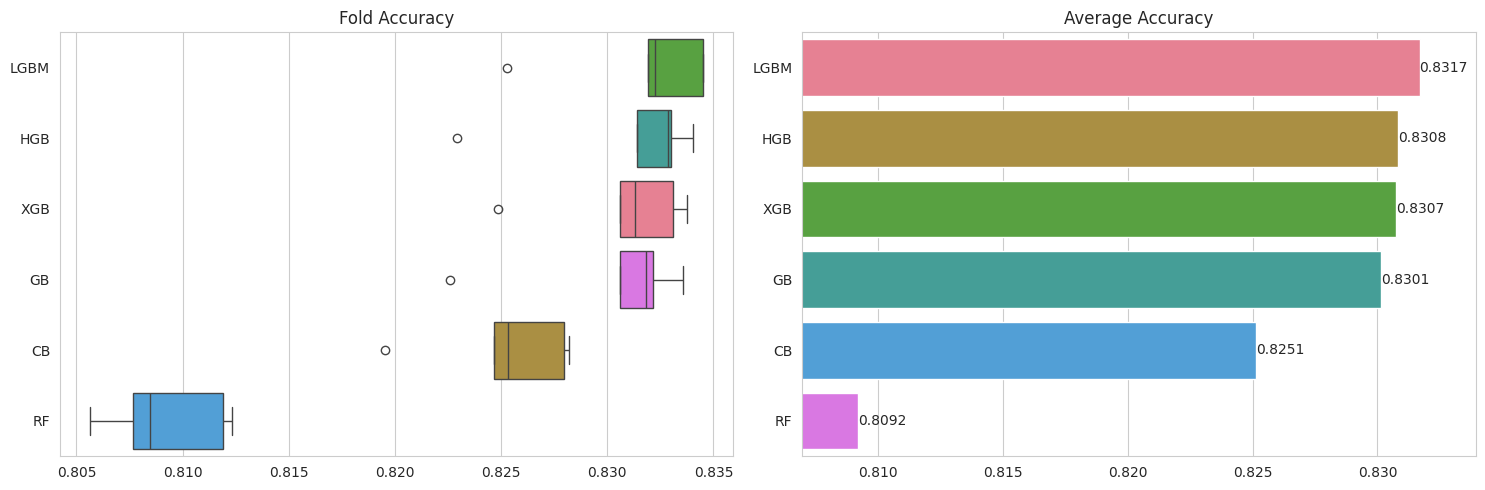

In [ ]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

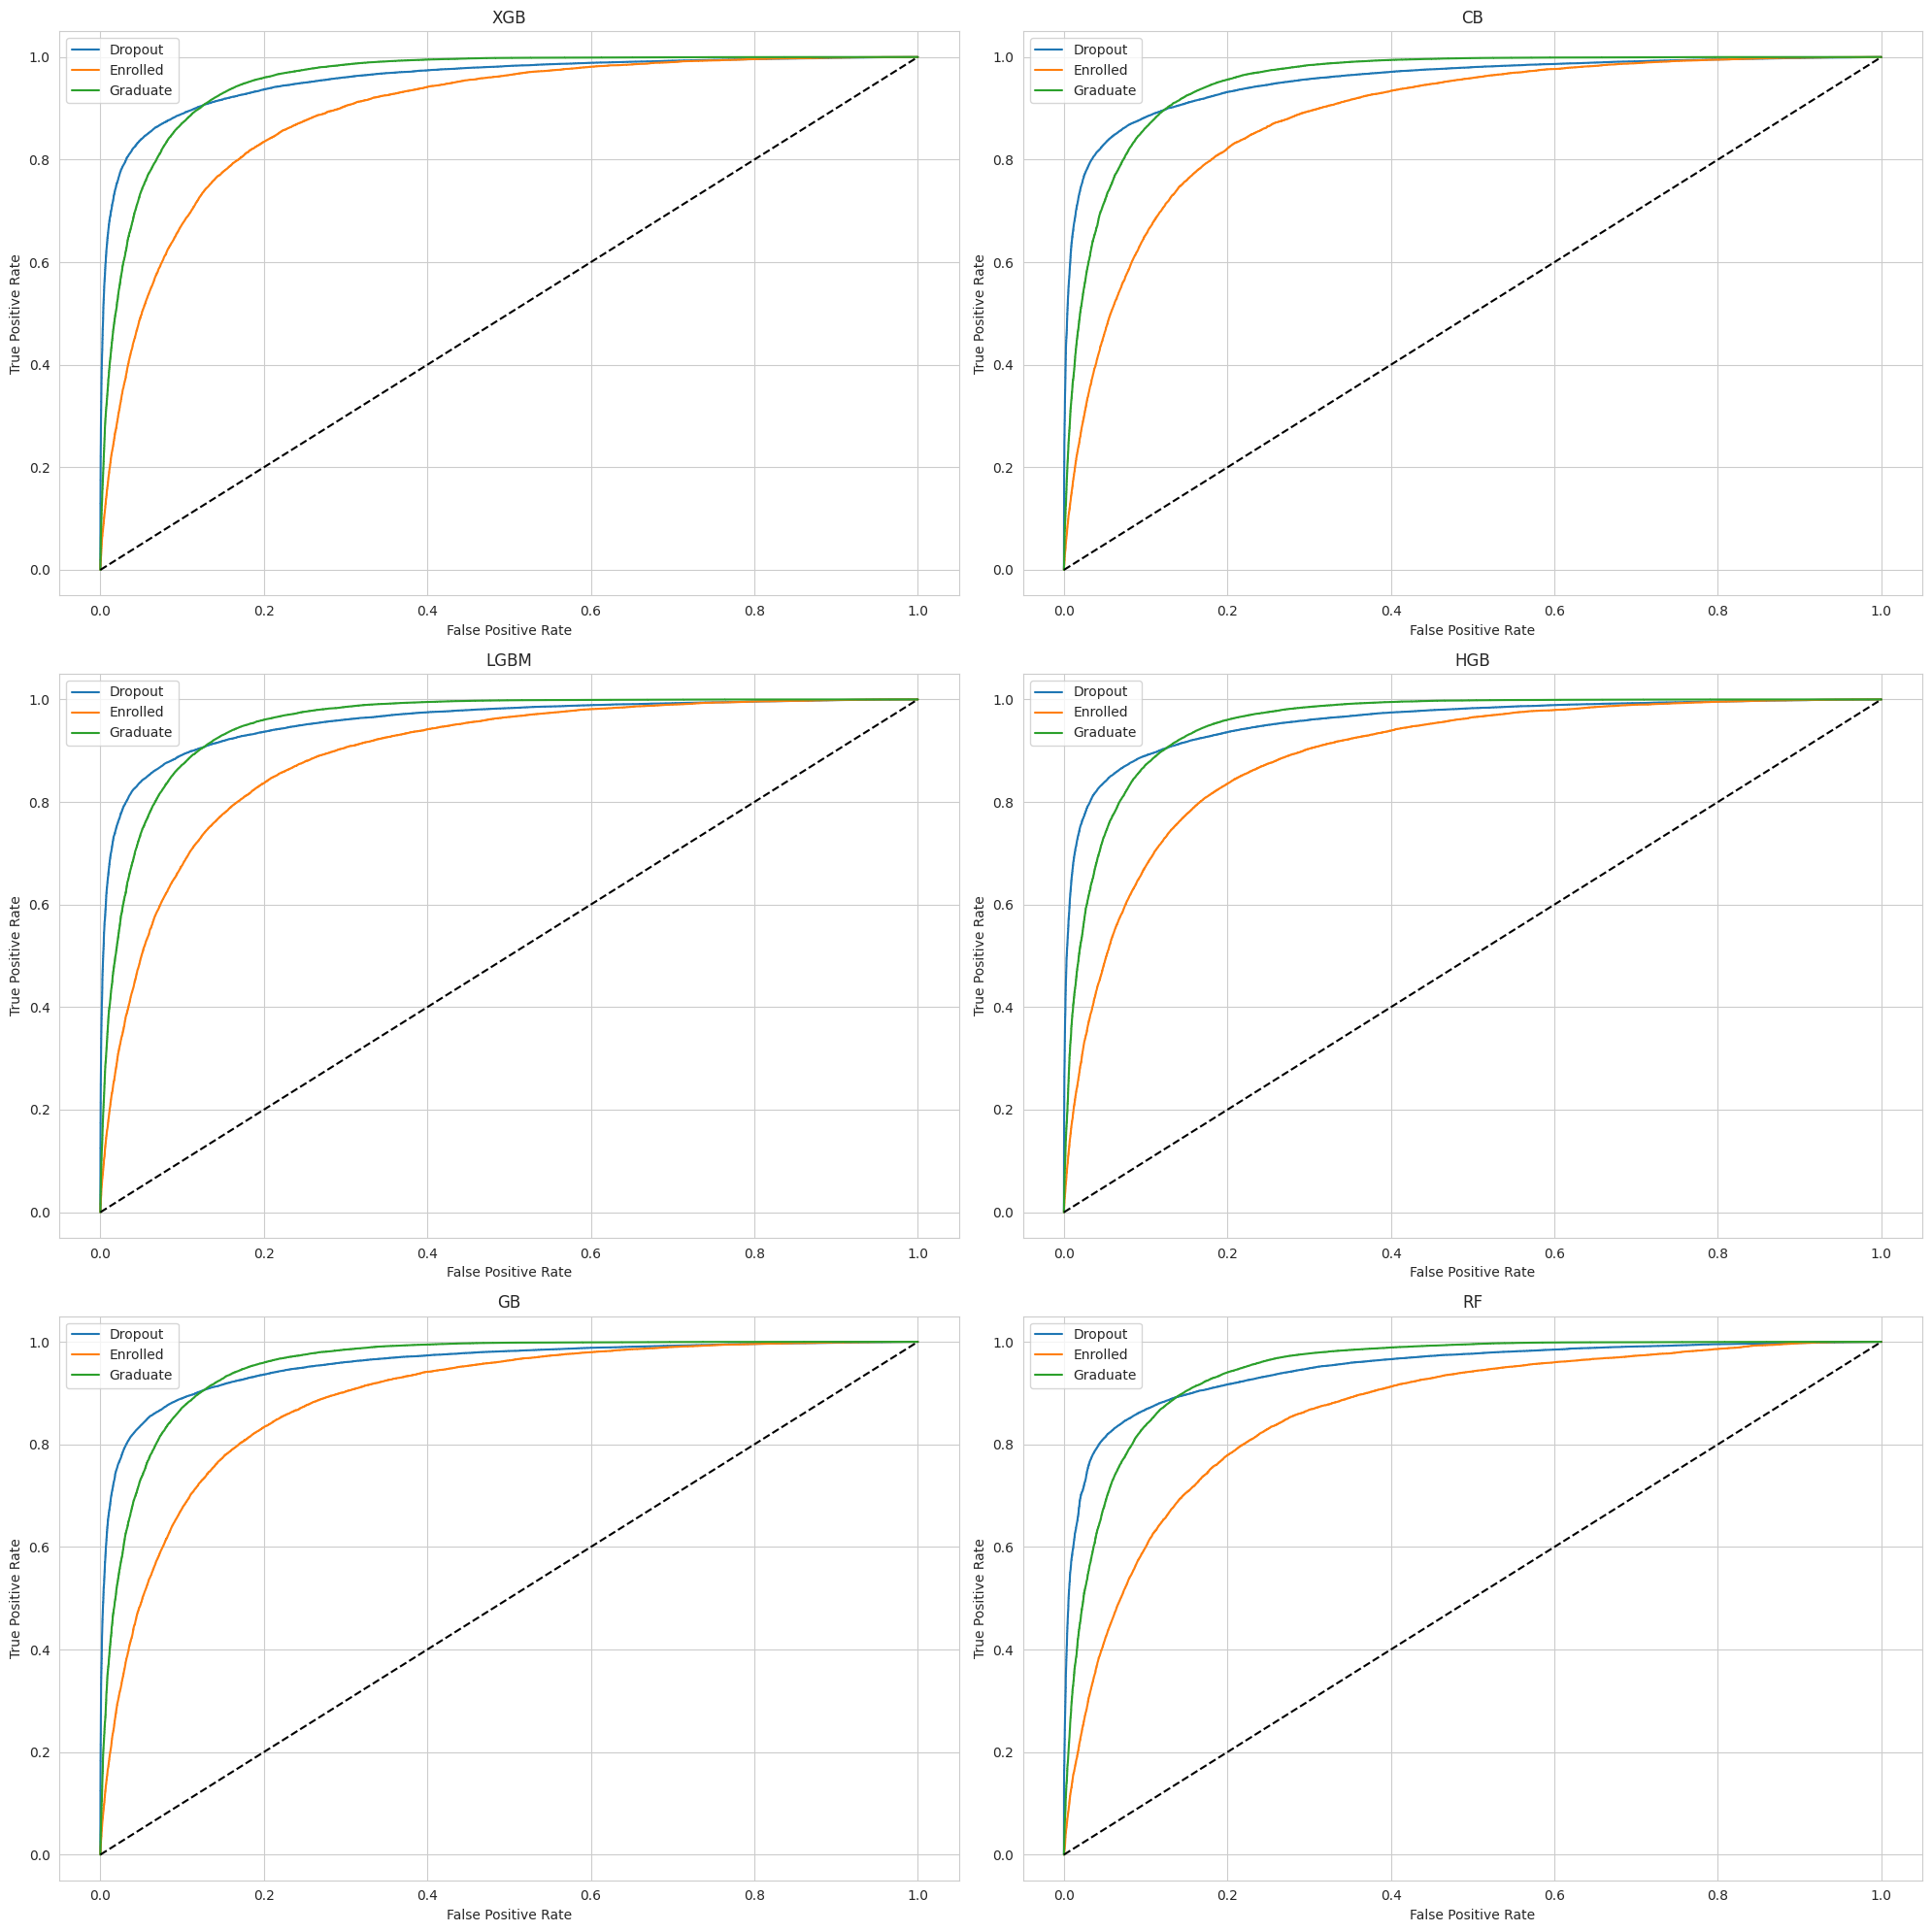

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    for i in range(pred_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y, pred_probs[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')

    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

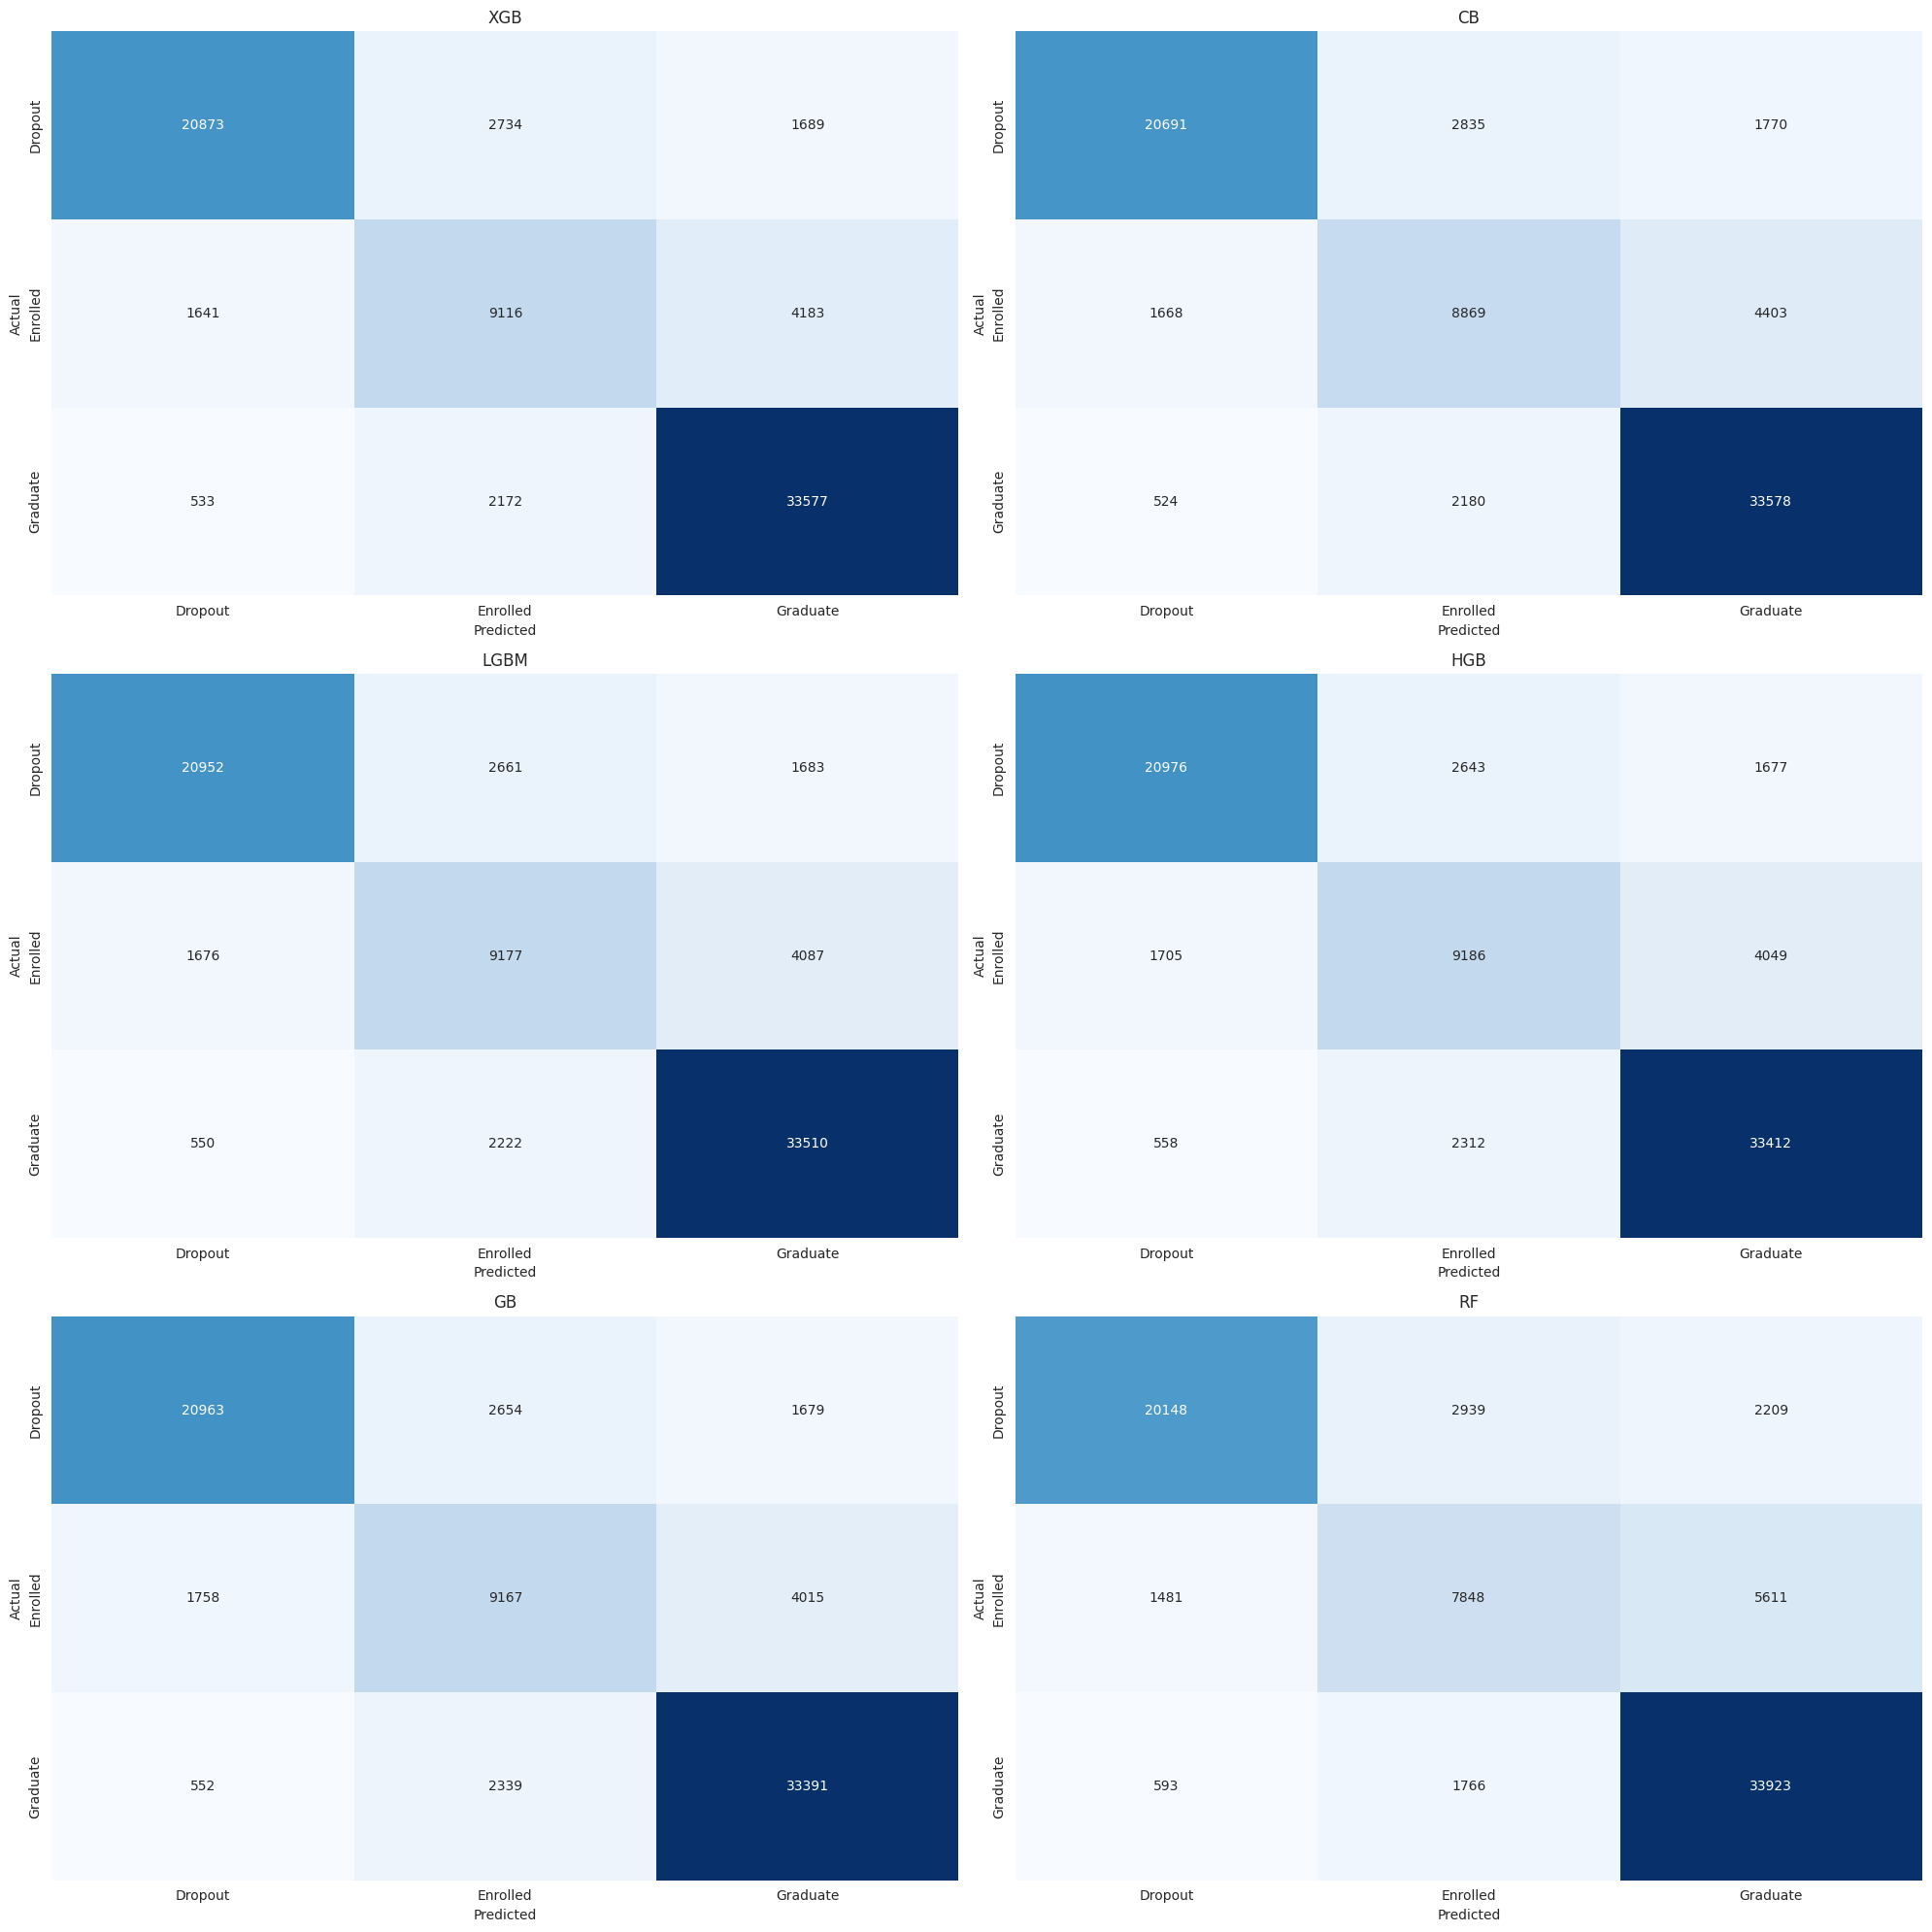

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for ax, (model, pred_probs) in zip(axs.flatten(), oof_pred_probs.items()):
    y_pred = np.argmax(pred_probs, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        ax=ax,
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        cbar=False,
        fmt='d'
    )
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:

submission = pd.DataFrame({'id': testing_data['id'], 'Target': prediction_mapped})
submission.to_csv('submission.csv', index=False)

NameError: name 'testing_data' is not defined